# General Prompt:
Choose ring neurons from the main FlyTable. <br>
Isolate the cable from soma to where the axon cable enters the ellipsoid body and determine that distance for each neuron. <br>
Determine if the morphologies of ring neurons correlate with their age predicted by cable length.

## to-do
- left/right separation or combination
- plot mean value + stdv

In [95]:
from fafbseg import flywire
import navis as navis

import seaserpent as ss

import math

import numpy as np
import pandas as pd

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from scipy.cluster.hierarchy import fcluster

import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import seaborn as sns
from scipy import stats

%env SEATABLE_TOKEN = 59481ea08c6a2ff4f3635ea54199520ce1a0f1dd
%env SEATABLE_SERVER = https://flytable.mrc-lmb.cam.ac.uk/

env: SEATABLE_TOKEN=59481ea08c6a2ff4f3635ea54199520ce1a0f1dd
env: SEATABLE_SERVER=https://flytable.mrc-lmb.cam.ac.uk/


In [2]:
# simple function to get all rows which have a specified descriptor in their "cell_class" field 
def class_from_main(class_desc):
    table = ss.Table(table="info").to_frame()
    sub = table[table.cell_class.isin([class_desc])]
    return sub

In [3]:
# the meat - explained in internal comments
def longest_axon_neurite(ids: list):
    #decide if worth parallelizing (long story) and heals nicely
    if len(ids)>5 and type(ids)!=str:
        skels = navis.heal_skeleton(flywire.skeletonize_neuron_parallel(ids))
    else:
        skels = navis.heal_skeleton(flywire.skeletonize_neuron(ids))
    #fetch synapses to allow for splitting
    flywire.synapses.fetch_synapses(skels, attach=True)
    #rerooting which philipp suggested as a good step somewhere
    for i in skels:
        navis.reroot_skeleton(i, i.soma, inplace=True)
    #split each neuron into axonic bit, dendritic bit, linker, and cell body fiber (segregation_index metric is the best)
    #this is needed to cover a scenario where the geodesic distance from soma to dendrite tip is shorter than geodesic distance from soma to axon tip
    skels_split = navis.split_axon_dendrite(skels, cellbodyfiber='soma', metric='segregation_index', omit_failures=True)
    #print(skels_split.soma)
    #now we keep everything that isn't a dendrite (so CBF, axon, linker)
    skels_keep = skels_split[skels_split.compartment!="dendrite"]
    skels_combed = navis.NeuronList(skels[0])
    #now we stitch those kept elements together - THIS DOES NOT PERFECTLY RECREATE THE NEURON MINUS THE DENDRITE if the dendrite region is some chunk of space along the CBF, not just the major split for dendrite
    for i in list(set(skels_keep.id)):
        skels_combed.append(navis.stitch_skeletons(skels_keep[skels_keep.id==i]))
    skels_healed = navis.heal_skeleton(skels_combed[1:])
    #we also return the full skels so we can use them for nblasting and not skeletonize twice, but because some of the splits fail this ensures we only keep good ones
    skels = skels[pd.Series(skels.id).isin(skels_healed.id)]
    #and we want to return only the longest neurite of the only axonal bits of neuron we have left, hence pruning by longest neurite
    return [skels, skels_healed.prune_by_longest_neurite(reroot_soma=True)]

In [4]:
#this removes anything in the mesh selected and returns only the bit of the neuron with the soma of the leftover fragments
def remove_in_mesh(neurites, mesh):
    pruned = neurites.prune_by_volume(mesh, 'OUT')
    frags = navis.NeuronList(pruned[0])
    for i in pruned:
        frag = navis.break_fragments(i)
        frags.append(frag)
    frags = frags[1:]
    out_frags = frags[frags.soma!=None]
    return out_frags

In [5]:
#make nblast before plotting so we only have to do once
def make_nblast(skels):
    dps = navis.make_dotprops(skels/1000)
    nbl = navis.nblast_allbyall(dps, progress=False)
    nbl_vec = squareform(((nbl + nbl.T) / 2 - 1) * -1, checks=False)
    Z_nbl = linkage(nbl_vec, method='ward', optimal_ordering=True)
    return Z_nbl

In [6]:
def sort_by_avg_lens(df, by, lens='lens'):
    df.sort_values(by=by, inplace=True)
    old_by = list(dict.fromkeys(df[by]))
    avg_lens = df.groupby([by]).mean()[lens]
    avg_lens_dict = dict(zip(old_by, avg_lens))
    avg_name = 'avg'+lens
    df[avg_name] = [avg_lens_dict[i] for i in df[by]]
    df.sort_values(by=[avg_name], inplace=True)
    return df

In [7]:
#anddddd plot
def plot_age_nbl_clust(z_nbl, cable_lens, t=1):
    Z_nbl = z_nbl
    cl = fcluster(Z_nbl, t, criterion='distance')
    zs = [np.array(z) for z in Z_nbl]
    zs.append([0,0,0,0])
    d = {'Z_nbl' : zs, 'lens' : cable_lens, 'cl' : cl}
    df = pd.DataFrame(data=d)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    dn1 = dendrogram(list(df.Z_nbl)[:-1], no_labels=True, color_threshold=t, ax=axes[0])
    df = sort_by_avg_lens(df, 'cl')
    colors = ['C'+str(i%10) for i in df.cl]
    df['colors'] = colors
    old_cl = list(dict.fromkeys(df.cl))
    new_cl = np.arange(max(df.cl))
    cl_dict = dict(zip(old_cl, new_cl))
    new_cl = [cl_dict[i]+1 for i in df.cl]
    df['cl_n'] = new_cl
    axes[1].scatter(df.lens, df.cl_n, c = df.colors)
#        axes[1].scatter(cl, cable_lens)
    statz=stats.pearsonr(df.lens, df.cl_n)
    print("r^2 = {:f}, p = {:f}".format(statz[0], statz[1]))

    plt.show()
    return df

In [111]:
def plot_age_type(types, cable_lens, sides = [], cmap='hsv'):
    all_types = list(set(types)) #gets all unique types, ignoring sides
    df = pd.DataFrame({"types":types, "lens":cable_lens}) #makes a df with type and len for each neuron
    df['color_num'] = [all_types.index(i) for i in df.types] #makes a color number for each type (basically whichever order it's in in the unique type set)
    colors = plt.cm.get_cmap(cmap, len(all_types)) #creates color map

    if len(sides)>0: #where the side array exists
        sides_options = list(set(sides))
        types = [t+'_'+s for t,s in zip(types, sides)] #add side to the type list
        sides_type_options = list(set(types)) #get unique list of sides+types combos (basically l/r for each type generally)
        df['side'] = sides #sets side col in df to sides array
        df['side_types'] = types #now sets the side and type combo into the side_types col in the df
        df['side_type_num'] = [sides_type_options.index(i) for i in df.side_types] #and creates a new # for the side_type combo for easying ID-ing later 

        df = sort_by_avg_lens(df, 'side_type_num') #and so sort by the specific side+type
    else:
        df = sort_by_avg_lens(df, 'color_num') #and if no sides then just sort by the type num ID

    if len(sides)>0:
        fig, axes = plt.subplots(1, len(sides_options), sharey=True)
        for ns, s in enumerate(sides_options):
            df_s = df[df.side==s]
            for n,i in enumerate(list(dict.fromkeys(df_s.side_type_num))):
                only_type = df_s[df_s.side_type_num==i]
                c = list(set(only_type.color_num))[0]
                axes[ns].scatter(np.full(len(only_type.lens), n), only_type.lens, color=colors(c))
        
    else:
        for n,i in enumerate(list(dict.fromkeys(df.color_num))):
            only_type = df[df.color_num==i]
            plt.scatter(np.full(len(only_type.lens), n), only_type.lens, color=colors(n))

            
    statz=stats.pearsonr(df.side_type_num, df.lens)
    print("r^2 = {:f}, p = {:f}".format(statz[0], statz[1]))

    plt.show()
    
    return df

In [9]:
def plot_3d_cell_types(skels, types, cmap = 'hsv', mesh=None):
    all_types = list(set(types))
    colors = plt.cm.get_cmap(cmap, len(all_types))
    c = [colors(all_types.index(i)) for i in types]
    col_map = dict(zip(skels.id, c))
    if mesh:
        navis.plot3d([mesh, skels], color=col_map)
    else:
        navis.plot3d(skels, color=col_map)
    return
        

In [10]:
ring_rows = class_from_main("ring neuron")
ring_ids = ring_rows.root_id
ring_types = ring_rows[['root_id', 'cell_type']] 

In [12]:
[ring_neurons, ring_neurites] = longest_axon_neurite(ring_ids)

Skeletonizing:   0%|          | 0/271 [00:00<?, ?it/s]

Healing:   0%|          | 0/271 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/10 [00:00<?, ?it/s]

Splitting:   0%|          | 0/271 [00:00<?, ?it/s]

Healing:   0%|          | 0/268 [00:00<?, ?it/s]

prune_by_longest_neurite:   0%|          | 0/268 [00:00<?, ?it/s]

In [13]:
eb_mesh = navis.read_mesh('./JFRC2NP.surf.FAFB14/EB.stl')

In [14]:
ring_cortex_neurites=remove_in_mesh(ring_neurites, eb_mesh)

prune_by_volume:   0%|          | 0/268 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/9 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/10 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/11 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/9 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/11 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/9 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/10 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/6 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/8 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/9 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/7 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/5 [00:00<?, ?it/s]

Breaking:   0%|          | 0/2 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/4 [00:00<?, ?it/s]

Breaking:   0%|          | 0/3 [00:00<?, ?it/s]

Breaking:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
z_nbl = make_nblast(ring_neurons)

Dividing:   0%|          | 0/268 [00:00<?, ?it/s]

Dotprops:   0%|          | 0/268 [00:00<?, ?it/s]

In [16]:
lens_pd = pd.merge(pd.DataFrame({"id": ring_neurons.id}),pd.DataFrame({"id":ring_cortex_neurites.id, "cable_length":ring_cortex_neurites.cable_length}), 
                      on = 'id', how='outer')

r^2 = 0.756459, p = 0.000000


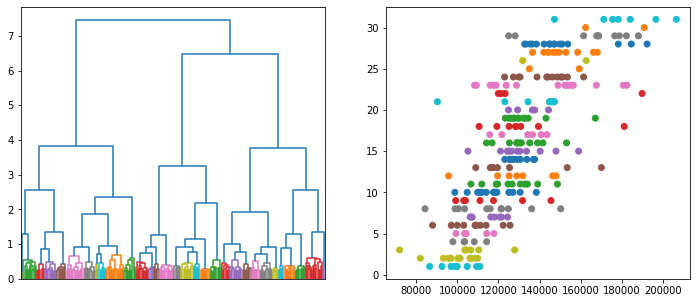

,Z_nbl,lens,cl,avglens,colors,cl_n
121,"[80.0, 330.0, 0.2771736091787173, 3.0]",104797.610666,29,99980.972871,C9,1
24,"[185.0, 222.0, 0.2215164486571074, 2.0]",98938.155016,29,99980.972871,C9,1
16,"[93.0, 201.0, 0.21223075441410844, 2.0]",99953.064727,29,99980.972871,C9,1
114,"[179.0, 133.0, 0.2751180605414899, 2.0]",92608.273908,29,99980.972871,C9,1
122,"[192.0, 285.0, 0.27749032926249323, 3.0]",86562.886685,29,99980.972871,C9,1
...,...,...,...,...,...,...
89,"[45.0, 345.0, 0.2582801882223735, 3.0]",171158.691898,9,179835.302774,C9,31
0,"[32.0, 17.0, 0.19129694108182382, 2.0]",196479.506395,9,179835.302774,C9,31
202,"[424.0, 368.0, 0.40749736442075274, 6.0]",206380.197083,9,179835.302774,C9,31
69,"[318.0, 276.0, 0.24385022296483852, 4.0]",175454.101979,9,179835.302774,C9,31


In [17]:
plot_age_nbl_clust(z_nbl, lens_pd.cable_length, t=.7)

In [97]:
ring_types = ring_rows[['root_id', 'cell_type', 'side']]
ring_types['root_id'] = pd.to_numeric(ring_rows.root_id)
ring_types = ring_types[ring_types.root_id.isin(ring_cortex_neurites.id)]
ring_types = pd.merge(pd.DataFrame({"root_id": ring_cortex_neurites.id}),ring_types, 
                      on = 'root_id', how='outer')

/var/folders/6x/5lwmcqxs2kq4j9b3q_2bk1j00000gq/T/ipykernel_2973/3357001062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ring_types['root_id'] = pd.to_numeric(ring_rows.root_id)


r^2 = 0.184776, p = 0.002390


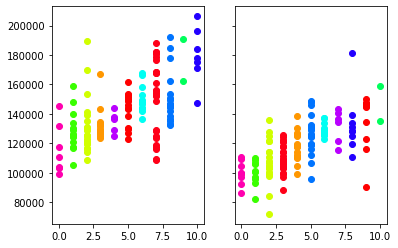

    types           lens  color_num   side  side_types  side_type_num        avglens
88   ER3p   86562.886685          9  right  ER3p_right              6   99980.972871
215  ER3p  109357.256080          9  right  ER3p_right              6   99980.972871
229  ER3p   98938.155016          9  right  ER3p_right              6   99980.972871
84   ER3p   92608.273908          9  right  ER3p_right              6   99980.972871
103  ER3p  110933.766735          9  right  ER3p_right              6   99980.972871
167  ER3p   96990.495845          9  right  ER3p_right              6   99980.972871
14   ER3p   99687.246177          9  right  ER3p_right              6   99980.972871
154  ER3p  104797.610666          9  right  ER3p_right              6   99980.972871
53   ER3p   99953.064727          9  right  ER3p_right              6   99980.972871
247  ER3w  100257.366370          3  right  ER3w_right             13  100132.759056
246  ER3w  108802.538197          3  right  ER3w_right           

In [112]:
print(plot_age_type(ring_types.cell_type, ring_cortex_neurites.cable_length, sides = ring_types.side).to_string())

In [ ]:
plot_3d_cell_types(ring_cortex_neurites, ring_types.cell_type)

# testing